## Problem Statement
Build your own recommendation system for products on an e-commerce website like Amazon.com.
Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. 
Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.
In this project we are going to build recommendation model for the electronics products of Amazon. 

## Import the required Libraries

In [1]:
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.model_selection import train_test_split

import Recommenders,Evaluation
from math import sqrt

## Lets Load the dataset and explore it

In [2]:
data_df = pd.read_csv('ratings_Electronics.csv')

In [3]:
#setting the column names
data_df.columns=['userId','productId','ratings','timestamp']

In [4]:
#Lets check the shape of the dataset to see the number or records and columns
data_df.shape

(7824481, 4)

In [5]:
data_df.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
#remvoing the timestamp column as its not required here for our analysis
data_df.drop('timestamp',axis=1,inplace=True)

In [7]:
data_df.head(2)

,userId,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0


In [8]:
#Lets check the shape again
data_df.shape

(7824481, 3)

In [9]:
#Lets check summary statistics
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [10]:
#Lets check summary of dataframe
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


- looking at the output there seems to be some null or missing values
- productId column holds numeric values however is shown as Object, there could be some Non-Numeric values in here, lets check that as well

In [11]:
#Lets check if there any duplicate rows in the dataset

data_df[data_df.duplicated()].count()

userId       0
productId    0
ratings      0
dtype: int64

In [12]:
#Lets check for null/NA values
data_df.isna().sum()
#Wow!! no NA values

userId       0
productId    0
ratings      0
dtype: int64

In [13]:
#Lets check if column productId has string values too

# Detecting non-numeric values in productId
cnt = 0
for value in data_df.iloc[:,1]:
    if not value.isdigit():
       cnt = cnt + 1

print("There are %s non-numeric values in productId out of %s Total"%(cnt,data_df['productId'].count()))

There are 7817768 non-numeric values in productId out of 7824481 Total


- Looks productId values can be of alphanumric type since there are many values which are non numeric, so nothing to take care of as of now

In [14]:
# Number of unique userId and productId in the dataset
print('Number of unique userId in data = ', data_df['userId'].nunique())
print('Number of unique productId in data = ', data_df['productId'].nunique())

Number of unique userId in data =  4201696
Number of unique productId in data =  476001


## Lets do some Visual Analysis

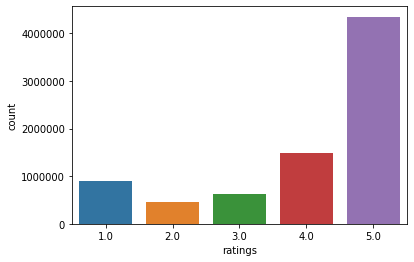

In [15]:
# Check counts of rating
sns.countplot(x='ratings',data=data_df)

In [16]:
pd.DataFrame({"rating count":data_df['ratings'].value_counts(),"Rating Percentage":(data_df['ratings'].value_counts()/data_df['ratings'].count())*100})

,rating count,Rating Percentage
5.0,4347540,55.563302
4.0,1485781,18.988876
1.0,901765,11.524918
3.0,633073,8.090926
2.0,456322,5.831978


- we can see that more than 50% of users given rating 5
- Least rating given by users is 2 , which is just 5%

In [17]:
#Since productId and usersId has nonNumeric values too, we cannot have Histogram for those

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: userId, dtype: int64

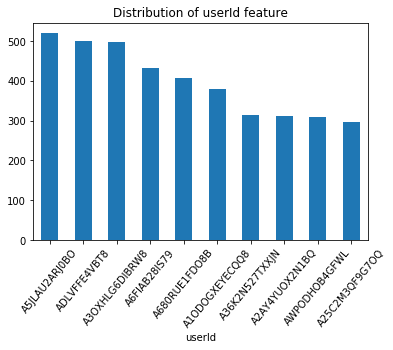

In [18]:
# Lets check users rating fequency, Top 10 users based on rating
data_df.groupby('userId')['userId'].count().sort_values(ascending=False).head(10).plot.bar(title='Distribution of userId feature',rot=50)
#data_df.groupby('userId').size().sort_values(ascending=False).head(10)
data_df.groupby('userId')['userId'].count().sort_values(ascending=False).head(10)

- we can see that userId A5JLAU2ARJ0BO has given 520 ratings, who is the highest among all

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: productId, dtype: int64

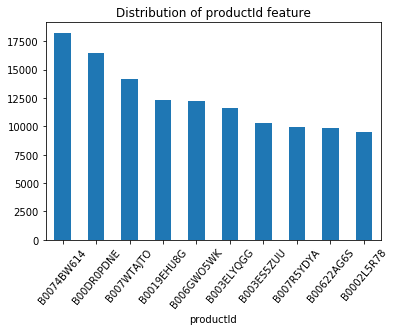

In [19]:
# Lets check productId rating frequency, Top 10 products based on rating count
data_df.groupby('productId')['productId'].count().sort_values(ascending=False).head(10).plot.bar(title='Distribution of productId feature',rot=50)
#data_df.groupby('productId').size().sort_values(ascending=False).head(10)
data_df.groupby('productId')['productId'].count().sort_values(ascending=False).head(10)

- we can see the top 10 product who have more ratings, the product B0074BW614 was rated 18244 times by the users

## Lets try to use the subset to build the model

#### Lets filter and use only the records where user has given more than 50 ratings

In [20]:
#Lets first find out users and ratings count
user_rating_counts =data_df.groupby('userId')['ratings'].count()
user_rating_counts =user_rating_counts.sort_values(ascending=False)
user_rating_counts.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: ratings, dtype: int64

In [21]:
#Now filter out and create dataset having rating count >=50 ( users who have rated more than 50 items)
data_df_subset = data_df[data_df['userId'].isin(user_rating_counts[user_rating_counts>=50].index)]
data_df_subset.head()

,userId,productId,ratings
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


In [22]:
data_df_subset.shape
# this reduced our dataset to around 125871 hundred records

(125871, 3)

In [23]:
#Lets check the data to confirm if the user rating count is >=50
data_df_subset.groupby('userId')['ratings'].count().sort_values().head()

userId
A2RS66Y79Q8X0W    50
A2Y4H3PXB07WQI    50
A3VZH0PWLQ9BB1    50
A19N3S7CBSU6O7    50
A1IU4UAV9QIJAI    50
Name: ratings, dtype: int64

#### Lets filter further and use only the records where product has more than 100 ratings

In [24]:
#Lets first find out products and ratings count
product_rating_counts =data_df_subset.groupby('productId')['ratings'].count()
product_rating_counts= product_rating_counts.sort_values(ascending=False)
product_rating_counts.head()

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

In [25]:
#Now filter out data_df_subset and create dataset having rating count >=50
data_df_final = data_df_subset[data_df_subset['productId'].isin(product_rating_counts[product_rating_counts>=50].index)]
data_df_final.head()

,userId,productId,ratings
72042,A2YRX8J4WM5BRX,B00004ZCJE,5.0
72058,AU627A4UGIW6V,B00004ZCJE,5.0
72076,A16RL0RMRF974O,B00004ZCJE,5.0
72120,AR8LWDT6TUKNZ,B00004ZCJE,5.0
72121,AD9ZL63H0VKCZ,B00004ZCJE,5.0


In [26]:
data_df_final.shape
# so this gives same number, which means all the productId in this subset dataset have received more than 500 ratings

(6234, 3)

In [27]:
#Lets check the data to confirm if the product rating count is >=50
data_df_final.groupby('productId')['ratings'].count().sort_values().head()

productId
B00JP12170    50
B009HQCAPQ    50
B003LSTD38    50
B000HPV3RW    51
B006I5MKZY    51
Name: ratings, dtype: int64

## Lets split the data in to training/test set

## Build Popularity Recommender model

In [28]:
#Lets build popularity based recommendation model based on average rating
#Lets take top 10 popular/highest rated products

In [29]:
#Lets first get average rating of each product
#products_avg_rating = train_data.groupby('productId')['productId','ratings'].mean()
products_avg_rating = data_df_final.groupby('productId')['productId','ratings'].mean()

In [30]:
products_avg_rating.shape

(77, 1)

In [31]:
#Now lets sort the data based on avg rating in descending order and take top 10 records
top_10_data = products_avg_rating.sort_values(by='ratings',ascending=False).head(10)
top_10_data

,ratings
productId,
B001TH7GUU,4.871795
B003ES5ZUU,4.864130
B0019EHU8G,4.855556
B006W8U2MU,4.824561
B000QUUFRW,4.809524
B000HPV3RW,4.803922
B001TH7GSW,4.803279
B000BQ7GW8,4.777778
B000N99BBC,4.772455


- we can see that the top rating we have is 5
- For average rating it important to consider the rating count as well, lets include that also while we consider mean/avg rating value

In [32]:
#Lets first get average rating of each product
products_avg_rating = data_df_final.groupby('productId')['productId','ratings'].mean()

In [33]:
#Lets add rating count to the same dataset and sort in descending order
products_avg_rating['ratings_count']= data_df_final.groupby('productId')['ratings'].count()
products_avg_rating = products_avg_rating.sort_values(by=['ratings_count','ratings'],ascending=[0,0]).reset_index()

In [34]:
#Now lets take top 10 records
top_10_data = products_avg_rating.head(10)
top_10_data

,productId,ratings,ratings_count
0,B0088CJT4U,4.218447,206
1,B003ES5ZUU,4.864130,184
2,B000N99BBC,4.772455,167
3,B007WTAJTO,4.701220,164
4,B00829TIEK,4.436242,149
5,B00829THK0,4.416058,137
6,B008DWCRQW,4.094891,137
7,B002R5AM7C,4.125000,128
8,B004CLYEDC,4.669492,118
9,B002SZEOLG,4.247788,113


#### So as per the popularity model above 10 products can be recommended to the users , however it remains same for all the usres as its based on popularity

In [35]:
def recommendProducts(userid,numberOfRecommendations):
    recommendations = products_avg_rating.head(numberOfRecommendations)
    recommendations['user']=userid
    #Bring user_id column to the front
    cols = recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    recommendations = recommendations[cols]
    return recommendations

In [36]:
recommendProducts('A5JLAU2ARJ0BO',10)

,user,productId,ratings,ratings_count
0,A5JLAU2ARJ0BO,B0088CJT4U,4.218447,206
1,A5JLAU2ARJ0BO,B003ES5ZUU,4.864130,184
2,A5JLAU2ARJ0BO,B000N99BBC,4.772455,167
3,A5JLAU2ARJ0BO,B007WTAJTO,4.701220,164
4,A5JLAU2ARJ0BO,B00829TIEK,4.436242,149
5,A5JLAU2ARJ0BO,B00829THK0,4.416058,137
6,A5JLAU2ARJ0BO,B008DWCRQW,4.094891,137
7,A5JLAU2ARJ0BO,B002R5AM7C,4.125000,128
8,A5JLAU2ARJ0BO,B004CLYEDC,4.669492,118
9,A5JLAU2ARJ0BO,B002SZEOLG,4.247788,113


In [37]:
recommendProducts('AT09WGFUM934H',10)

,user,productId,ratings,ratings_count
0,AT09WGFUM934H,B0088CJT4U,4.218447,206
1,AT09WGFUM934H,B003ES5ZUU,4.864130,184
2,AT09WGFUM934H,B000N99BBC,4.772455,167
3,AT09WGFUM934H,B007WTAJTO,4.701220,164
4,AT09WGFUM934H,B00829TIEK,4.436242,149
5,AT09WGFUM934H,B00829THK0,4.416058,137
6,AT09WGFUM934H,B008DWCRQW,4.094891,137
7,AT09WGFUM934H,B002R5AM7C,4.125000,128
8,AT09WGFUM934H,B004CLYEDC,4.669492,118
9,AT09WGFUM934H,B002SZEOLG,4.247788,113


- ### We can see that from the above 2 results the recommendation for both the users is same, this is how it is in popularity based recommendation system

## Build Collaborative Recommender model

### User based Collaborative filter

In [38]:
# Lets take only few set for building the model

#data_newdf = data_df.iloc[0:100000,:]
#data_newdf.shape

In [39]:
data_df_final.shape

(6234, 3)

In [40]:
data_df_final.head()

,userId,productId,ratings
72042,A2YRX8J4WM5BRX,B00004ZCJE,5.0
72058,AU627A4UGIW6V,B00004ZCJE,5.0
72076,A16RL0RMRF974O,B00004ZCJE,5.0
72120,AR8LWDT6TUKNZ,B00004ZCJE,5.0
72121,AD9ZL63H0VKCZ,B00004ZCJE,5.0


In [41]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df_UBCF = data_df_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df_UBCF.head()

productId,B00004ZCJE,B00007E7JU,B0002L5R78,B000BQ7GW8,B000HPV3RW,B000JE7GPY,B000JMJWV2,B000LRMS66,B000N99BBC,B000Q8UAWY,...,B009SYZ8OC,B00AQRUW4Q,B00ARB5FLQ,B00BGGDVOO,B00BOHNYTW,B00BOHNYU6,B00DR0PDNE,B00G4UQ6U8,B00HFRWWAM,B00JP12170
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#Lets check the shape of the metrix
pivot_df_UBCF.shape

(1357, 77)

In [43]:
#Lets check the density of the metrix

given_number_of_ratings=np.count_nonzero(pivot_df_UBCF)
print('Given number of ratings = %d'%(given_number_of_ratings))
possible_number_of_ratings = pivot_df_UBCF.shape[0]*pivot_df_UBCF.shape[1]
print('possible number of ratings = %d'%(possible_number_of_ratings))
density =(given_number_of_ratings/possible_number_of_ratings)*100
print('density = %4.2f'%(density))

Given number of ratings = 6234
possible number of ratings = 104489
density = 5.97


- 5.97% which is very less

### Lets apply SVD

In [44]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df_UBCF, k = 20)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [45]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df_UBCF.columns)
preds_df.head()

productId,B00004ZCJE,B00007E7JU,B0002L5R78,B000BQ7GW8,B000HPV3RW,B000JE7GPY,B000JMJWV2,B000LRMS66,B000N99BBC,B000Q8UAWY,...,B009SYZ8OC,B00AQRUW4Q,B00ARB5FLQ,B00BGGDVOO,B00BOHNYTW,B00BOHNYU6,B00DR0PDNE,B00G4UQ6U8,B00HFRWWAM,B00JP12170
0,0.132551,-0.025600,-0.059772,0.612840,0.150106,0.112120,0.386347,0.576507,-0.309410,0.402041,...,-0.337698,0.364438,0.010122,0.100578,0.464816,0.310534,0.131335,0.896980,0.117375,0.066943
1,0.459364,0.259686,0.942526,0.337365,0.645151,0.263636,0.868992,0.877133,0.109066,-0.087092,...,0.604511,1.219101,0.540672,0.924159,0.074484,0.363857,0.243061,0.436758,-0.086504,0.352786
2,-0.523315,-0.289259,0.756521,-0.287561,-0.068003,0.378590,-0.027548,0.360148,4.913172,-0.281763,...,-0.443675,0.589102,0.744628,-0.106215,0.294520,1.466353,-0.014117,0.422016,0.874364,0.538941
3,0.009442,-0.210311,0.018476,0.116320,0.346773,-0.133293,0.166765,0.509399,-0.209215,0.932581,...,0.024625,0.148514,0.002185,0.381021,0.402802,0.390072,0.116005,-0.491662,-0.353303,0.062122
4,-0.137713,-0.178609,-0.370196,-0.289931,0.014775,0.193827,0.486279,0.642404,0.275330,0.234367,...,0.737875,0.954952,0.654664,-0.240603,0.088562,0.541228,-0.256961,-0.202192,0.610347,0.409604


In [46]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [47]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 28
num_recommendations = 5
recommend_items(userID, pivot_df_UBCF, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 28):

                   user_ratings  user_predictions
Recommended Items                                
B00HFRWWAM                  0.0          2.401997
B0081FLFQE                  0.0          1.959295
B00ARB5FLQ                  0.0          1.582749
B002SQK2F2                  0.0          1.519199
B001CHHVCU                  0.0          1.364900


### Evaluation of Model-based Collaborative Filtering (SVD)

In [48]:
rmse_df = pd.concat([pivot_df_UBCF.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(77, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
B00004ZCJE,0.225497,0.210107,0
B00007E7JU,0.195284,0.154763,1
B0002L5R78,0.227708,0.233160,2
B000BQ7GW8,0.190125,0.185655,3
B000HPV3RW,0.180545,0.187238,4


In [49]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01973 



- ### We can see that with user based collaborative filter we were able to recommend some of the product to the user based on similarity of his behaviour with other users
- ### as per the UBCF , we evaluated RMSE socre as 0.019

### Item Based Collaborative Filter

In [50]:
#Lets now try to build recommendation model using IBCF

In [51]:
#Item-based Collaborative Filtering, build item-user matrix
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
pivot_df_IBCF = data_df_final.pivot(index = 'productId', columns ='userId', values = 'ratings').fillna(0)
pivot_df_IBCF.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
B00004ZCJE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00007E7JU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002L5R78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
B000BQ7GW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0
B000HPV3RW,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#Lets check the shape of the metrix
pivot_df_IBCF.shape

(77, 1357)

In [53]:
#Lets check the density of the metrix ( it will be same as that of UBCF)

given_number_of_ratings=np.count_nonzero(pivot_df_IBCF)
print('Given number of ratings = %d'%(given_number_of_ratings))
possible_number_of_ratings = pivot_df_IBCF.shape[0]*pivot_df_IBCF.shape[1]
print('possible number of ratings = %d'%(possible_number_of_ratings))
density =(given_number_of_ratings/possible_number_of_ratings)*100
print('density = %4.2f'%(density))

Given number of ratings = 6234
possible number of ratings = 104489
density = 5.97


### Lets apply SVD

In [54]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df_IBCF, k = 20)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [55]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df_IBCF.columns)
preds_df.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
0,0.132551,0.459364,-0.523315,0.009442,-0.137713,-0.467512,-0.118752,1.589299,-0.712942,0.064446,...,-0.012064,0.459685,0.077278,1.352245,-0.210438,0.559785,0.036891,0.188695,0.092844,0.131826
1,-0.025600,0.259686,-0.289259,-0.210311,-0.178609,-0.235595,-0.053983,0.913968,-0.428279,0.107930,...,-0.094792,0.420470,-0.099385,0.796407,0.208203,0.385699,0.020457,-0.001655,-0.105268,0.263006
2,-0.059772,0.942526,0.756521,0.018476,-0.370196,0.154636,-0.353235,0.200352,0.517873,-0.029031,...,0.377335,1.536596,0.172478,-0.073046,0.035605,0.734992,0.011755,1.128089,0.643346,1.114543
3,0.612840,0.337365,-0.287561,0.116320,-0.289931,0.259087,-0.121287,1.411839,0.180479,1.009097,...,0.093587,0.049255,-0.181194,0.726929,0.134797,0.675361,0.085797,1.774311,0.279238,0.158188
4,0.150106,0.645151,-0.068003,0.346773,0.014775,0.204145,0.181599,0.360500,0.044962,0.202721,...,0.638892,0.399727,0.013126,0.147622,0.465650,0.372823,0.016020,1.191963,0.062500,0.662408


In [56]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 28
num_recommendations = 5
recommend_items(userID, pivot_df_IBCF, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 28):

                   user_ratings  user_predictions
Recommended Items                                
A16QODENBJVUI1              0.0          2.460205
A23ZNGL704AW7O              0.0          2.248488
A2XCCN239AR1XK              0.0          2.209056
A19XMHRB3G4DIR              0.0          2.016447
A15XI2BEGGFEOW              0.0          1.873191


### Evaluation of Model-based Collaborative Filtering (SVD)

In [57]:
rmse_df = pd.concat([pivot_df_IBCF.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(1357, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
userId,,,
A100UD67AHFODS,0.194805,0.172875,0
A100WO06OQR8BQ,0.584416,0.635836,1
A105S56ODHGJEK,0.428571,0.476923,2
A105TOJ6LTVMBG,0.129870,0.124435,3
A10AFVU66A79Y1,0.285714,0.285548,4


In [58]:

RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.03117 



- ### We can see that with item based collaborative filter we were able to recommend some of the product to the user based on similarity of the items he has rated
- ### as per the IBCF , we evaluated RMSE socre as 0.031

## Lets build model using surprise library

In [59]:
#Lets import surprise package

from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, accuracy , Prediction, SVD

In [60]:
reader = Reader(rating_scale=(1,5))

In [61]:
#Lets read our final dataset (subset that we have created)
data = Dataset.load_from_df(data_df_final,reader)

In [62]:
# Lets split the data with train test

trainset,testset = train_test_split(data,test_size=0.3,random_state=28)

In [63]:
#lets build the model ITEM_BASED
model = KNNWithMeans(k=20,sim_options={'name':'pearson','user_based':False})
model.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [64]:
#lets predict the rating on testset
test_pred = model.test(testset)

In [65]:
# conver the prediction data to dataframe

test_pred_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in test_pred],columns=['userId','productId','est_rating'])
test_pred_df.sort_values(by=['userId','est_rating'],ascending=False,inplace=True)
test_pred_df.head()

,userId,productId,est_rating
1336,AZOK5STV85FBJ,B0002L5R78,4.645833
123,AZNUHQSHZHSUE,B000N99BBC,5.000000
731,AZMY6E8B52L2T,B003ES5ZUU,5.000000
1709,AZMY6E8B52L2T,B0019EHU8G,4.897059
1510,AZMY6E8B52L2T,B001TH7GUU,4.890909


In [66]:
#Lets select only top 10 product recommendation for each user
top10_records = test_pred_df.groupby('userId').head(10).reset_index(drop=True)
top10_records.head()

,userId,productId,est_rating
0,AZOK5STV85FBJ,B0002L5R78,4.645833
1,AZNUHQSHZHSUE,B000N99BBC,5.000000
2,AZMY6E8B52L2T,B003ES5ZUU,5.000000
3,AZMY6E8B52L2T,B0019EHU8G,4.897059
4,AZMY6E8B52L2T,B001TH7GUU,4.890909


In [67]:
top10_records.groupby('userId')['productId'].size().head()

userId
A100WO06OQR8BQ    3
A105S56ODHGJEK    1
A105TOJ6LTVMBG    1
A10H24TDLK2VDP    3
A10NMELR4KX0J6    2
Name: productId, dtype: int64

 - you can notice that only few recommendation is given for few users like A105S56ODHGJEK has only one recommendation

In [68]:
testset_new=trainset.build_anti_testset()
test_pred_df=model.test(testset_new)
test_pred_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in test_pred_df],columns=['userId','productId','est_rating'])
test_pred_df.sort_values(by=['userId','est_rating'],ascending=False,inplace=True)
test_pred_df.head()

,userId,productId,est_rating
90015,AZOK5STV85FBJ,B001TH7GSW,4.947368
90077,AZOK5STV85FBJ,B006W8U2MU,4.906250
90020,AZOK5STV85FBJ,B0019EHU8G,4.897059
90021,AZOK5STV85FBJ,B003ES5ZUU,4.845528
90056,AZOK5STV85FBJ,B000BQ7GW8,4.828571


In [69]:
#Lets select only top 10 product recommendation for each user
top10_records = test_pred_df.groupby('userId').head(10).reset_index(drop=True)
top10_records.head(30)

,userId,productId,est_rating
0,AZOK5STV85FBJ,B001TH7GSW,4.947368
1,AZOK5STV85FBJ,B006W8U2MU,4.906250
2,AZOK5STV85FBJ,B0019EHU8G,4.897059
3,AZOK5STV85FBJ,B003ES5ZUU,4.845528
4,AZOK5STV85FBJ,B000BQ7GW8,4.828571
5,AZOK5STV85FBJ,B00G4UQ6U8,4.800000
6,AZOK5STV85FBJ,B000QUUFRW,4.776119
7,AZOK5STV85FBJ,B000HPV3RW,4.756757
8,AZOK5STV85FBJ,B00BOHNYTW,4.755102
9,AZOK5STV85FBJ,B002WE6D44,4.727273


In [70]:
#Lets check top10 recommendaiton for user 'AZMY6E8B52L2T'
top10_records[top10_records['userId']=='AZMY6E8B52L2T']

,userId,productId,est_rating
20,AZMY6E8B52L2T,B003ES5ZUU,5.000000
21,AZMY6E8B52L2T,B004CLYEFK,5.000000
22,AZMY6E8B52L2T,B0079UAT0A,5.000000
23,AZMY6E8B52L2T,B002WE4HE2,5.000000
24,AZMY6E8B52L2T,B0074BW614,5.000000
25,AZMY6E8B52L2T,B001TH7GSW,4.947368
26,AZMY6E8B52L2T,B006W8U2MU,4.906250
27,AZMY6E8B52L2T,B0034CL2ZI,4.905576
28,AZMY6E8B52L2T,B000JE7GPY,4.900000
29,AZMY6E8B52L2T,B0019EHU8G,4.897059


In [71]:
print('\nRMSE SVD Model = %f \n'%(accuracy.rmse(test_pred)))

RMSE: 0.9201

RMSE SVD Model = 0.920147 



- ### We can see that with surprise library item based collaborative filter we were able to recommend some of the product to the user based on similarity of the items he has rated
- ### as per the IBCF , we evaluated RMSE socre as 0.92

# Summary

- EDA, DataLoading, Analysis
> - We loaded the data set and added column names as the given dataset did not have the names, also we removed one of the column timestamp which was irrelavant to us for this analsysi
> - As part of EDA we checked for datatypes of each column, also checked if there were any duplicates and Null/NA values in the given dataset. Surprisingly we did not find any issue with these
> - We then checked number of unique user and product count in given dataset
> - We then proceeded with visual analysis, initial we checked for frequency distribution of ratings & found out that 55% of users have given 5 rating and less than 6% ratings given as rating 2
> - We then checked frequency distribution of users based on rating count, i.e tried to find out the total ratings given by each users. We found that maximum of 520 ratings were given by one of the user
> - We also checked frequency distribution of products based on rating count, i.e number of ratings each product has received. We found out that the maximum rating that a product has received is 18244

- Reduce sparsity/less denser
> - Since there were many records in given dataset and not all users had given rating to all products or not all products had received ratings for users, considering this we decided to take subset of the given dataset to reduce sparse
> - To start with we decided to consider only the users who have rated more than or equal to 50 items
> - Then to reduce the sparsity furhter we decided to take only those records from above first subset to consider only those products which has received more than or equal to 50 ratings count
> - After all this filtering, we ended up with dataset size 6234 records

- Building Model
> - Popularity Recommender Model
> > - In this case we usually recommend the most popular items based on the ratings, higher the average rating higher chance to recommend it
> > - For this recommendation we first calculated average rating of each product and sorted the records in descending order of avg ratings ( in this case it was required to consider the number of ratings count too)
> - User based Collaborative filter
> > - To start with we generated user-items matrix, then used SVD to factorize the matrix
> > - with this aproach we calcuated the ratings that each user would give to the item and based on this matrix we suggest the items with highest predicted ratings to the user
> > - For evaluated this model we calculated RMSE ( root mean squared error), which came out to be 0.019
> - Item based Collaborative filter
> > - To start with we generated items-users matrix( transpose of user-item matrix), then used SVD to factorize the matrix
> > - with this aproach we calcuated the ratings that each user would give to the item and based on this matrix we suggest the items with highest predicted ratings to the user
> > - For evaluated this model we calculated RMSE ( root mean squared error), which came out to be 0.031,  which is better than UBCF

- Building Model with Surprise library
> - We used python library surprise to build the item based recommender system
> - We split the dataset into trainset and test set with 70:30 ratio
> - We then used KNNWithMeans built in algorithm of surprise to build model, we also used pearson similarity ( and consider item based collaborative )
> - With this we predicted the estimated rating that each product would get from the users
> - we then sorted the predicted dataset with descending order of est_rating grouping by user and suggest top 10 items to each user
> - To evaluate the model we used built-in accuracy to calculate RMSE , which was showing as 0.92

- Final Statement
> - Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.
> - The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user. but Collaborative Filtering based model has recommended entire different list based on the user past purchase history